In [1]:
import findspark
findspark.init('/usr/local/spark')
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("Python Linear Regression example").getOrCreate()

In [4]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

In [5]:
import matplotlib.pyplot as plt
import pandas
import numpy

In [6]:
data = spark.read.load("linregdata1.csv", format="csv", sep=",", inferSchema="true", header="true")
data.printSchema()

root
 |-- temperature: double (nullable = true)
 |-- exhaust_vacuum: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- relative_humidity: double (nullable = true)
 |-- energy_output: double (nullable = true)



In [7]:
data.describe()

DataFrame[summary: string, temperature: string, exhaust_vacuum: string, ambient_pressure: string, relative_humidity: string, energy_output: string]

In [8]:
data.show(10)

+-----------+--------------+----------------+-----------------+-------------+
|temperature|exhaust_vacuum|ambient_pressure|relative_humidity|energy_output|
+-----------+--------------+----------------+-----------------+-------------+
|       8.34|         40.77|         1010.84|            90.01|       480.48|
|      23.64|         58.49|          1011.4|             74.2|       445.75|
|      29.74|          56.9|         1007.15|            41.91|       438.76|
|      19.07|         49.69|         1007.22|            76.79|       453.09|
|       11.8|         40.66|         1017.13|             97.2|       464.43|
|      13.97|         39.16|         1016.05|             84.6|       470.96|
|       22.1|         71.29|          1008.2|            75.38|       442.35|
|      14.47|         41.76|         1021.98|            78.41|        464.0|
|      31.25|         69.51|         1010.25|            36.83|       428.77|
|       6.77|         38.18|          1017.8|            81.13| 

In [9]:
features = ["temperature", "exhaust_vacuum", "ambient_pressure", "relative_humidity"]

In [10]:
lr_data = data.select(col("energy_output").alias("label"), *features)
lr_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- exhaust_vacuum: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- relative_humidity: double (nullable = true)



In [11]:
lr_data.show()

+------+-----------+--------------+----------------+-----------------+
| label|temperature|exhaust_vacuum|ambient_pressure|relative_humidity|
+------+-----------+--------------+----------------+-----------------+
|480.48|       8.34|         40.77|         1010.84|            90.01|
|445.75|      23.64|         58.49|          1011.4|             74.2|
|438.76|      29.74|          56.9|         1007.15|            41.91|
|453.09|      19.07|         49.69|         1007.22|            76.79|
|464.43|       11.8|         40.66|         1017.13|             97.2|
|470.96|      13.97|         39.16|         1016.05|             84.6|
|442.35|       22.1|         71.29|          1008.2|            75.38|
| 464.0|      14.47|         41.76|         1021.98|            78.41|
|428.77|      31.25|         69.51|         1010.25|            36.83|
|484.31|       6.77|         38.18|          1017.8|            81.13|
|435.29|      28.28|         68.67|         1006.36|             69.9|
|451.4

In [12]:
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")

In [13]:
va_data = vectorAssembler.transform(lr_data)

In [14]:
va_data.show(truncate=False)

+------+-----------+--------------+----------------+-----------------+---------------------------+
|label |temperature|exhaust_vacuum|ambient_pressure|relative_humidity|unscaled_features          |
+------+-----------+--------------+----------------+-----------------+---------------------------+
|480.48|8.34       |40.77         |1010.84         |90.01            |[8.34,40.77,1010.84,90.01] |
|445.75|23.64      |58.49         |1011.4          |74.2             |[23.64,58.49,1011.4,74.2]  |
|438.76|29.74      |56.9          |1007.15         |41.91            |[29.74,56.9,1007.15,41.91] |
|453.09|19.07      |49.69         |1007.22         |76.79            |[19.07,49.69,1007.22,76.79]|
|464.43|11.8       |40.66         |1017.13         |97.2             |[11.8,40.66,1017.13,97.2]  |
|470.96|13.97      |39.16         |1016.05         |84.6             |[13.97,39.16,1016.05,84.6] |
|442.35|22.1       |71.29         |1008.2          |75.38            |[22.1,71.29,1008.2,75.38]  |
|464.0 |14

In [15]:
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [16]:
ss_model = standardScaler.fit(va_data)

In [17]:
ss_data = ss_model.transform(va_data)

In [18]:
ss_data.show(truncate=False)

+------+-----------+--------------+----------------+-----------------+---------------------------+-----------------------------------------------------------------------------+
|label |temperature|exhaust_vacuum|ambient_pressure|relative_humidity|unscaled_features          |features                                                                     |
+------+-----------+--------------+----------------+-----------------+---------------------------+-----------------------------------------------------------------------------+
|480.48|8.34       |40.77         |1010.84         |90.01            |[8.34,40.77,1010.84,90.01] |[1.1190915744403476,3.208242310929751,170.20993692880273,6.164955008688884]  |
|445.75|23.64      |58.49         |1011.4          |74.2             |[23.64,58.49,1011.4,74.2]  |[3.1721012973345104,4.602651281978933,170.30423233131958,5.082098229582438]  |
|438.76|29.74      |56.9          |1007.15         |41.91            |[29.74,56.9,1007.15,41.91] |[3.99062151365179

In [19]:
(training, test) = ss_data.randomSplit([.7, .3])

In [20]:
training.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|             label|      temperature|    exhaust_vacuum|  ambient_pressure| relative_humidity|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|              6707|             6707|              6707|              6707|              6707|
|   mean|454.23292530192185|19.73281049649623| 54.42809154614546|1013.2259847920095| 73.12272401968089|
| stddev|17.046698223146212|7.450770552469753|12.667412508549864| 5.900834187243241|14.702437751353031|
|    min|            421.57|             1.81|             25.36|            992.89|             25.89|
|    max|            495.35|            37.11|             80.18|            1033.3|            100.16|
+-------+------------------+-----------------+------------------+------------------+------------------+



In [21]:
test.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|             label|       temperature|    exhaust_vacuum|  ambient_pressure| relative_humidity|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              2861|              2861|              2861|              2861|              2861|
|   mean| 454.6746522195038|19.459986018874506| 54.01912617965746|1013.3366585110097| 73.74560992659909|
| stddev|17.113469658981003| 7.454265967798913|12.799932473809145| 6.027139577601238|14.350976303387093|
|    min|            420.26|              2.34|             25.36|            994.17|             25.56|
|    max|            495.76|             35.56|             81.56|           1033.25|            100.13|
+-------+------------------+------------------+------------------+------------------+------------------+



In [22]:
lr = LinearRegression(maxIter=10, regParam=.01)

In [23]:
lr_model = lr.fit(training)

In [24]:
lr_model.coefficients

DenseVector([-14.7507, -2.9982, 0.3173, -2.3238])

In [25]:
lr_model.intercept

463.63677380296656

In [26]:
trainingSummary = lr_model.summary

In [27]:
trainingSummary.rootMeanSquaredError

4.515131371560683

In [28]:
trainingSummary.meanAbsoluteError

3.6182049592429606

In [29]:
trainingSummary.meanSquaredError

20.386411302451453

In [30]:
trainingSummary.r2

0.9298342788140297

In [31]:
prediction_df = lr_model.transform(test)

In [32]:
prediction_df.show(truncate=False)

+------+-----------+--------------+----------------+-----------------+---------------------------+---------------------------------------------------------------------------+------------------+
|label |temperature|exhaust_vacuum|ambient_pressure|relative_humidity|unscaled_features          |features                                                                   |prediction        |
+------+-----------+--------------+----------------+-----------------+---------------------------+---------------------------------------------------------------------------+------------------+
|420.26|24.27      |63.87         |1018.88         |53.96            |[24.27,63.87,1018.88,53.96]|[3.256636991806623,5.026010213369712,171.5637494935089,3.6958223782785486] |446.37678330746525|
|425.11|32.56      |68.14         |1004.02         |35.04            |[32.56,68.14,1004.02,35.04]|[4.36901938414601,5.362021855941948,169.06155363386543,2.3999558216249137] |431.1783105635492 |
|425.16|30.71      |71.85     

In [33]:
prediction_df.select("label","prediction").show(truncate=False)

+------+------------------+
|label |prediction        |
+------+------------------+
|420.26|446.37678330746525|
|425.11|431.1783105635492 |
|425.16|428.290622957224  |
|425.19|428.23874000134686|
|425.21|429.3886368493837 |
|425.29|433.70964477980124|
|425.3 |429.10312770571454|
|425.34|430.43360067269106|
|425.36|431.66592256523796|
|425.48|430.2914260862586 |
|425.55|432.7629938695283 |
|425.58|428.47413024085483|
|425.64|433.0932672413676 |
|425.82|433.01484070056273|
|425.91|430.2153762224568 |
|426.0 |432.49253400598786|
|426.07|428.09394897682733|
|426.13|433.563687812273  |
|426.22|424.9965235306457 |
|426.25|433.3844390395301 |
+------+------------------+
only showing top 20 rows



In [34]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [35]:
rmse = eval.evaluate(prediction_df)
print("RMSE: %.3f" % rmse)

RMSE: 4.655


In [36]:
mse = eval.evaluate(prediction_df, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

MSE: 21.671


In [37]:
mae = eval.evaluate(prediction_df, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

MAE: 3.641


In [38]:
r2 = eval.evaluate(prediction_df, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.926


In [39]:
data = spark.read.load("simple_regression_data.csv", format="csv", sep=",", inferSchema="true", header="true")
data.printSchema()

root
 |-- Volume: double (nullable = true)
 |-- Price: double (nullable = true)



In [40]:
data.describe()

DataFrame[summary: string, Volume: string, Price: string]

In [41]:
features = ["Volume"]

In [42]:
lr_data = data.select(col("Price").alias("label"), *features)
lr_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- Volume: double (nullable = true)



In [43]:
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")

In [44]:
va_data = vectorAssembler.transform(lr_data)

In [45]:
va_data.show(truncate=False)

+------------------+------------------+--------------------+
|label             |Volume            |unscaled_features   |
+------------------+------------------+--------------------+
|27.00038919371711 |4.690627620390215 |[4.690627620390215] |
|24.92512584073805 |4.235715795914122 |[4.235715795914122] |
|20.931068455655385|4.626837890601358 |[4.626837890601358] |
|31.2963211589208  |6.166306770544403 |[6.166306770544403] |
|17.315908997701225|3.4337593562714916|[3.4337593562714916]|
|34.81630627133921 |5.945952605654652 |[5.945952605654652] |
|15.999181612465863|4.6324153993109665|[4.6324153993109665]|
|25.06119875135152 |3.959436725068601 |[3.959436725068601] |
|23.585336663915907|3.923684856715232 |[3.923684856715232] |
|31.88904082235074 |5.6056967481810736|[5.6056967481810736]|
|28.839020809838416|5.024370878579448 |[5.024370878579448] |
|33.309405223122226|6.3113353402836845|[6.3113353402836845]|
|26.414694146580658|5.624020755105372 |[5.624020755105372] |
|23.46569128576979 |4.75

In [46]:
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [47]:
ss_model = standardScaler.fit(va_data)

In [48]:
ss_data = ss_model.transform(va_data)

In [49]:
ss_data.show(truncate=False)

+------------------+------------------+--------------------+-------------------+
|label             |Volume            |unscaled_features   |features           |
+------------------+------------------+--------------------+-------------------+
|27.00038919371711 |4.690627620390215 |[4.690627620390215] |[6.003237848484713]|
|24.92512584073805 |4.235715795914122 |[4.235715795914122] |[5.4210249542983]  |
|20.931068455655385|4.626837890601358 |[4.626837890601358] |[5.921597404773426]|
|31.2963211589208  |6.166306770544403 |[6.166306770544403] |[7.89186633135891] |
|17.315908997701225|3.4337593562714916|[3.4337593562714916]|[4.394651590023824]|
|34.81630627133921 |5.945952605654652 |[5.945952605654652] |[7.609848961873642]|
|15.999181612465863|4.6324153993109665|[4.6324153993109665]|[5.928735705678026]|
|25.06119875135152 |3.959436725068601 |[3.959436725068601] |[5.067432832076915]|
|23.585336663915907|3.923684856715232 |[3.923684856715232] |[5.021676275252834]|
|31.88904082235074 |5.605696

In [50]:
(training2, test2) = ss_data.randomSplit([.7, .3])

In [51]:
lr2 = LinearRegression(maxIter=10, regParam=.01)

In [52]:
lr_model2 = lr2.fit(training2)

In [53]:
trainingSummary2 = lr_model2.summary

In [54]:
trainingSummary2.r2

0.6461923155224047

In [55]:
prediction_df2 = lr_model2.transform(test2)

In [56]:
rmse = eval.evaluate(prediction_df2)
print("RMSE: %.3f" % rmse)

RMSE: 2.973


In [57]:
test2 = test2.toPandas()
prediction_df2 = prediction_df2.toPandas()
prediction_df2.head()

,label,Volume,unscaled_features,features,prediction
0,11.561399,2.428696,[2.4286962171930115],[3.1083347972764073],12.491257
1,13.942244,2.856219,[2.85621933815121],[3.6554946207682275],14.601268
2,14.801247,3.359659,[3.359659208190056],[4.2998154935477215],17.085962
3,14.812500,4.361301,[4.361300686638186],[5.581753119099794],22.029496
4,15.478300,3.832794,[3.8327943809803386],[4.905351299544551],19.421089


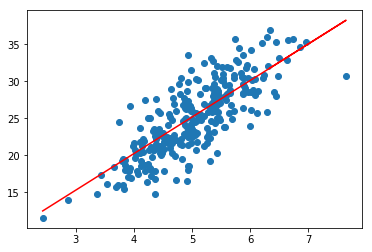

In [58]:
plt.scatter(x = test2['Volume'],y = test2['label'])
plt.plot(prediction_df2['Volume'],prediction_df2['prediction'], color='red')

In [59]:
from pyspark.ml.recommendation import ALS

In [60]:
retailData = spark.read.load("retail_2013.csv", format="csv", inferSchema="true", header="false")
retailData.count()

2554634

In [61]:
retailData.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: timestamp (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: integer (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: integer (nullable = true)



In [67]:
retailData.show(5)

+---+-------------------+------+--------------------+--------------------+---+-----+---+
|_c0|                _c1|   _c2|                 _c3|                 _c4|_c5|  _c6|_c7|
+---+-------------------+------+--------------------+--------------------+---+-----+---+
|  1|2013-01-01 01:41:46|443111|Household applian...|       Refrigerators|875|14640|  1|
|  1|2013-01-01 02:18:34| 45322|Gift  novelty  an...|         Sun glasses| 58|12503|  1|
|  1|2013-01-01 12:09:03|   446|Health and person...|     Health monitors|184|16266|  1|
|  1|2013-01-01 00:10:20|  4421|    Furniture stores|Study room furniture|209|16625|  1|
|  1|2013-01-01 13:39:08| 44413|     Hardware stores|                Saws| 57|16194|  1|
+---+-------------------+------+--------------------+--------------------+---+-----+---+
only showing top 5 rows



In [62]:
from pyspark.ml.feature import StringIndexer

In [63]:
indexer = StringIndexer(inputCol="_c4", outputCol="ProductIndex")
retailData1 = indexer.fit(retailData).transform(retailData)

In [65]:
retailData1.show(10,truncate=False)

+---+-------------------+------+-------------------------------------+--------------------+----+-----+---+------------+
|_c0|_c1                |_c2   |_c3                                  |_c4                 |_c5 |_c6  |_c7|ProductIndex|
+---+-------------------+------+-------------------------------------+--------------------+----+-----+---+------------+
|1  |2013-01-01 01:41:46|443111|Household appliance stores           |Refrigerators       |875 |14640|1  |68.0        |
|1  |2013-01-01 02:18:34|45322 |Gift  novelty  and souvenir stores   |Sun glasses         |58  |12503|1  |97.0        |
|1  |2013-01-01 12:09:03|446   |Health and personal care stores      |Health monitors     |184 |16266|1  |32.0        |
|1  |2013-01-01 00:10:20|4421  |Furniture stores                     |Study room furniture|209 |16625|1  |17.0        |
|1  |2013-01-01 13:39:08|44413 | Hardware stores                     |Saws                |57  |16194|1  |57.0        |
|1  |2013-01-01 22:13:46|44312 | Compute

In [66]:
retailData2 = retailData1.select('ProductIndex',col("_c6").alias("CustomerId"))
retailData2.printSchema()
retailData2.show(5)

root
 |-- ProductIndex: double (nullable = true)
 |-- CustomerId: integer (nullable = true)

+------------+----------+
|ProductIndex|CustomerId|
+------------+----------+
|        68.0|     14640|
|        97.0|     12503|
|        32.0|     16266|
|        17.0|     16625|
|        57.0|     16194|
+------------+----------+
only showing top 5 rows



In [68]:
retailData3=retailData2.groupBy("ProductIndex", "CustomerId").count()

In [69]:
retailData3.printSchema()
retailData3.show()


root
 |-- ProductIndex: double (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- count: long (nullable = false)

+------------+----------+-----+
|ProductIndex|CustomerId|count|
+------------+----------+-----+
|        17.0|     10024|    1|
|        58.0|     13278|    1|
|         3.0|     15331|    1|
|        34.0|     13037|    2|
|        96.0|     26986|    1|
|       130.0|     27242|    1|
|       153.0|     40674|    1|
|        44.0|     40769|    1|
|        97.0|     57281|    1|
|       155.0|     50594|    1|
|        14.0|     54659|    1|
|        56.0|     57917|    1|
|        66.0|     67818|    1|
|        80.0|     63618|    1|
|        67.0|     72022|    1|
|       120.0|     76786|    1|
|        87.0|     70551|    1|
|       149.0|     79213|    2|
|       147.0|     71824|    1|
|        36.0|     83221|    2|
+------------+----------+-----+
only showing top 20 rows



In [94]:
retailData3.agg({"Number":"sum"}).collect()

[Row(sum(count)=2554634)]

In [98]:
retailData3.agg({"ProductIndex":"sum"}).collect()

[Row(sum(ProductIndex)=184860163.0)]

In [72]:
retailData4=retailData3.withColumn("Count", expr("CAST(count AS DOUBLE)"))

In [73]:
retailData4.printSchema()
retailData4.show()

root
 |-- ProductIndex: double (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Count: double (nullable = false)

+------------+----------+-----+
|ProductIndex|CustomerId|Count|
+------------+----------+-----+
|        17.0|     10024|  1.0|
|        58.0|     13278|  1.0|
|         3.0|     15331|  1.0|
|        34.0|     13037|  2.0|
|        96.0|     26986|  1.0|
|       130.0|     27242|  1.0|
|       153.0|     40674|  1.0|
|        44.0|     40769|  1.0|
|        97.0|     57281|  1.0|
|       155.0|     50594|  1.0|
|        14.0|     54659|  1.0|
|        56.0|     57917|  1.0|
|        66.0|     67818|  1.0|
|        80.0|     63618|  1.0|
|        67.0|     72022|  1.0|
|       120.0|     76786|  1.0|
|        87.0|     70551|  1.0|
|       149.0|     79213|  2.0|
|       147.0|     71824|  1.0|
|        36.0|     83221|  2.0|
+------------+----------+-----+
only showing top 20 rows



In [74]:
als = ALS(maxIter=5, regParam=0.01, userCol="CustomerId", itemCol="ProductIndex", ratingCol="Count", implicitPrefs=True, alpha=1.0)

In [75]:
model = als.fit(retailData4)

In [76]:
#a dataframe, productDF that contains distinct product names and product indexes


In [79]:
productDF = retailData1.select(col("_c4").alias("ProductName"),'ProductIndex').distinct()
productDF.count()

160

In [80]:
productDF.orderBy('ProductIndex').show()

+--------------------+------------+
|         ProductName|ProductIndex|
+--------------------+------------+
|            Perfumes|         0.0|
|      Airated drinks|         1.0|
|  Mystery & thriller|         2.0|
|         Dishwashers|         3.0|
|       Other jewelry|         4.0|
|     Packaged fruits|         5.0|
|      Wheels & Tires|         6.0|
|       Running shoes|         7.0|
| Parts & Accessories|         8.0|
|      Personal items|         9.0|
|     Steoreo Systems|        10.0|
|             Juicers|        11.0|
|        Writing aids|        12.0|
|       Classic books|        13.0|
|       Arts & Crafts|        14.0|
| Dolls & accessories|        15.0|
|Engine & Drive train|        16.0|
|Study room furniture|        17.0|
|     Loose gemstones|        18.0|
|Boating & water s...|        19.0|
+--------------------+------------+
only showing top 20 rows



In [86]:
testDF=productDF.withColumn('CustomerId', lit(43124)).withColumn('Count', lit(0.0))
testDF2=productDF.withColumn('CustomerId', lit(99970)).withColumn('Count', lit(0.0))

In [87]:
predictions = model.transform(testDF)
predictions2 = model.transform(testDF2)
predictions.printSchema()

root
 |-- ProductName: string (nullable = true)
 |-- ProductIndex: double (nullable = true)
 |-- CustomerId: integer (nullable = false)
 |-- Count: double (nullable = false)
 |-- prediction: float (nullable = true)



In [88]:
predictions.orderBy("prediction", ascending=False).limit(5).show()
predictions2.orderBy("prediction", ascending=False).limit(5).show()

+--------------------+------------+----------+-----+----------+
|         ProductName|ProductIndex|CustomerId|Count|prediction|
+--------------------+------------+----------+-----+----------+
|Cell phones & acc...|       132.0|     43124|  0.0| 0.5584805|
|Harddrives & Storage|       107.0|     43124|  0.0| 0.5417448|
|      Golf equipment|        69.0|     43124|  0.0| 0.5165956|
|Chocolates & Candies|       103.0|     43124|  0.0| 0.5154564|
|   Printing supplies|       119.0|     43124|  0.0| 0.5143153|
+--------------------+------------+----------+-----+----------+

+--------------------+------------+----------+-----+----------+
|         ProductName|ProductIndex|CustomerId|Count|prediction|
+--------------------+------------+----------+-----+----------+
|            Perfumes|         0.0|     99970|  0.0| 0.5074477|
|   Printing supplies|       119.0|     99970|  0.0|0.47133556|
|Chocolates & Candies|       103.0|     99970|  0.0|0.42440596|
|       Running shoes|         7.0|    

In [135]:
sample_reco = spark.read.load("sample_recommendation.csv", format="csv", inferSchema="true", header="false")
sample_reco.show()

+----------+------+-----+------+
|       _c0|   _c1|  _c2|   _c3|
+----------+------+-----+------+
|01/23/2005| 50000|India|  Beer|
|01/27/2005|380000|India|Whisky|
|02/12/2005| 45000|India|   Rum|
|01/23/2006|500000|  USA|  Beer|
|01/27/2006|550000|  USA|   Rum|
|02/12/2006|650000|  USA|Whisky|
|01/23/2006|500000|China|  Beer|
|01/27/2006|550000|China|Whisky|
|02/12/2006|650000|China|   Rum|
+----------+------+-----+------+



In [136]:
indexer = StringIndexer(inputCol="_c3", outputCol="ProductIndex")
indexer2 = StringIndexer(inputCol="_c2", outputCol="Country")
sample_reco = indexer.fit(sample_reco).transform(sample_reco)
sample_reco = indexer2.fit(sample_reco).transform(sample_reco)
sample_reco.show()

+----------+------+-----+------+------------+-------+
|       _c0|   _c1|  _c2|   _c3|ProductIndex|Country|
+----------+------+-----+------+------------+-------+
|01/23/2005| 50000|India|  Beer|         2.0|    2.0|
|01/27/2005|380000|India|Whisky|         0.0|    2.0|
|02/12/2005| 45000|India|   Rum|         1.0|    2.0|
|01/23/2006|500000|  USA|  Beer|         2.0|    1.0|
|01/27/2006|550000|  USA|   Rum|         1.0|    1.0|
|02/12/2006|650000|  USA|Whisky|         0.0|    1.0|
|01/23/2006|500000|China|  Beer|         2.0|    0.0|
|01/27/2006|550000|China|Whisky|         0.0|    0.0|
|02/12/2006|650000|China|   Rum|         1.0|    0.0|
+----------+------+-----+------+------------+-------+



In [137]:
sample_reco1=sample_reco.groupBy("ProductIndex", "Country").count()
sample_reco1=sample_reco1.withColumn("Count", expr("CAST(count AS DOUBLE)"))
sample_reco1.show()

+------------+-------+-----+
|ProductIndex|Country|Count|
+------------+-------+-----+
|         2.0|    0.0|  1.0|
|         1.0|    1.0|  1.0|
|         0.0|    1.0|  1.0|
|         2.0|    2.0|  1.0|
|         1.0|    0.0|  1.0|
|         2.0|    1.0|  1.0|
|         1.0|    2.0|  1.0|
|         0.0|    0.0|  1.0|
|         0.0|    2.0|  1.0|
+------------+-------+-----+



In [138]:
als = ALS(maxIter=5, regParam=0.01, userCol="Country", itemCol="ProductIndex", ratingCol="Count", implicitPrefs=True, alpha=1.0)

In [139]:
model3 = als.fit(sample_reco1)

In [140]:
sample_productDF = sample_reco.select(col("_c3").alias("ProductName"),'ProductIndex').distinct()
sample_productDF.show()

+-----------+------------+
|ProductName|ProductIndex|
+-----------+------------+
|     Whisky|         0.0|
|       Beer|         2.0|
|        Rum|         1.0|
+-----------+------------+



In [141]:
sample_testDF = sample_productDF.withColumn('Country', lit(2.0)).withColumn('Count', lit(0.0))
sample_testDF.printSchema()
sample_testDF.show()

root
 |-- ProductName: string (nullable = true)
 |-- ProductIndex: double (nullable = true)
 |-- Country: double (nullable = false)
 |-- Count: double (nullable = false)

+-----------+------------+-------+-----+
|ProductName|ProductIndex|Country|Count|
+-----------+------------+-------+-----+
|     Whisky|         0.0|    2.0|  0.0|
|       Beer|         2.0|    2.0|  0.0|
|        Rum|         1.0|    2.0|  0.0|
+-----------+------------+-------+-----+



In [142]:
predictions3 = model3.transform(sample_testDF)
predictions3.printSchema()

root
 |-- ProductName: string (nullable = true)
 |-- ProductIndex: double (nullable = true)
 |-- Country: double (nullable = false)
 |-- Count: double (nullable = false)
 |-- prediction: float (nullable = true)



In [143]:
predictions3.orderBy("prediction", ascending=False).show()

+-----------+------------+-------+-----+----------+
|ProductName|ProductIndex|Country|Count|prediction|
+-----------+------------+-------+-----+----------+
|        Rum|         1.0|    2.0|  0.0| 0.9977778|
|       Beer|         2.0|    2.0|  0.0| 0.9977778|
|     Whisky|         0.0|    2.0|  0.0| 0.9977778|
+-----------+------------+-------+-----+----------+



In [145]:
sample_testDF2 = sample_productDF.withColumn('Country', lit(0.0)).withColumn('Count', lit(0.0))
predictions4 = model3.transform(sample_testDF2)
predictions4.orderBy("prediction", ascending=False).show()

+-----------+------------+-------+-----+----------+
|ProductName|ProductIndex|Country|Count|prediction|
+-----------+------------+-------+-----+----------+
|        Rum|         1.0|    0.0|  0.0| 0.9977778|
|       Beer|         2.0|    0.0|  0.0| 0.9977778|
|     Whisky|         0.0|    0.0|  0.0| 0.9977778|
+-----------+------------+-------+-----+----------+

